# Heart Failure Prediction

Link: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

## Introduccion
Se trata de un dataset con 13 atributos, 2 de estos atributos no deberian de usarse para el training (`time` y `DEATH_EVENT`) ya que significan cuando ha fallecido una persona o cuando se ha perdido el contacto con una persona y si la persona ha fallecido o no.

Este dataset se utilizo por Davide Chicco y Giuseppe Jurman en la generacion de un modelo que podia predecir la supervivencia de pacientes solamente segun su suero de creatinina y la fraccion de ejeccion.

### Objetivos
Poder predecir si una persona podria tener riesgo de fallo de corazon mortal para poder tomar las medidas necesarias para reducir la mortalidad de estos sucesos.  
Por esta razon el atributo objetivo a predecir sera `DEATH_EVENT`. A parte nos interesa tener un recall lo mas grande posible debido a la naturaleza de las predicciones clinicas.

### Manejo de outliers
Si tuviesemos un dataset mas grande podriamos eliminar los outliers mas facilmente y sin repercusiones para evitar overfitting.
En este caso, tenemos un dataset bastante pequeño (299 muestras) por lo tanto antes de borrar un outlier lo intentaremos analizar para ver porque es un outlier y si de verdad haria falta borrarlo.



## Cargar dataset
En este apartado cargaremos el dataset y observaremos la distribucion de los datos y las correlaciones que puede haber

In [1]:
import pandas as pd

dataframe = pd.read_csv("../../data/heart_failure_clinical_records_dataset.csv")

dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [2]:
dataframe.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Seleccion de datos
Despues de haber examinado las columnas del dataset se puede ver que todas estas podrian influir en el resultado, aunque no directamente.  
Mas adelante se examinarán y evaluarán numericamente las correlaciones de todos estos atributos con el atributo objetivo para poder investigarlos mas detalladamente.

## Normalizacion del dataset
Es muy importante a la hora de analizar relaciones entre datos y entrenar modelos trabajar con datos normalizados ya que de esta manera todos los datos tendran rangos parecidos y no habra atributos que pesen mas que otros, en cambio con datos no normalizados podria pasar que un atributo tenga demasiado peso al tener un valor de rangos muy alto a comparacion de otro atributo que alomejor tiene mas relacion con los datos que estamos tratando pero al tener un rango de valores muy bajo no se tiene en cuenta.

### Atributos binarios y discretos
En nuestro dataset tenemos atributos que tienen 2 posibles valores (0 y 1).  
Los atributos binarios y discretos no se deberian de normalizar como norma general, ya que estos pueden perder significado al alterarlos.  
En el caso de los atributos discretos se deberia de hacer algun preprocesamiento de datos especial. Como nuestro dataset solo tiene atributos binarios o continuos no tendremos que preocuparnos de esto.  
Para poder tratar a nuestros atributos binarios mejor y que sean quantificativos con ambos valores reasignaremos los valores para que sean:
- Positivo : 1
- Negativo : -1

In [3]:
from sklearn.preprocessing import scale

columnas_continuas = [0, 2, 4, 6, 7, 8]  # la columna 11 no hace falta normalizarla ya que no la usaremos
columnas_binarias = [1, 3, 5, 9, 10]     # la columna 12 no hace falta modificarla ya que se trata del atributo objetivo de un problema de clasificacion

def normalizacion_dataset(data_in):
    data_out = data_in.copy()
    data_out[data_out.columns[columnas_continuas]] = scale(data_out[data_out.columns[columnas_continuas]])
    for col in columnas_binarias:
        es_negativo = data_out[data_out.columns[col]]==0
        data_out.loc[es_negativo, data_out.columns[col]] = -1
    return data_out

data_norm = normalizacion_dataset(dataframe)
data_norm.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,2.990000e+02,299.000000,299.000000,299.000000,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,2.990000e+02,299.000000,299.000000,299.000000,299.00000
mean,5.703353e-16,-0.137124,0.000000,-0.163880,-3.267546e-17,-0.297659,7.723291e-17,1.425838e-16,-8.673849e-16,0.297659,-0.357860,130.260870,0.32107
std,1.001676e+00,0.992215,1.001676,0.988134,1.001676e+00,0.956273,1.001676e+00,1.001676e+00,1.001676e+00,0.956273,0.935341,77.614208,0.46767
min,-1.754448e+00,-1.000000,-0.576918,-1.000000,-2.038387e+00,-1.000000,-2.440155e+00,-8.655094e-01,-5.363206e+00,-1.000000,-1.000000,4.000000,0.00000
25%,-8.281242e-01,-1.000000,-0.480393,-1.000000,-6.841802e-01,-1.000000,-5.208700e-01,-4.782047e-01,-5.959961e-01,-1.000000,-1.000000,73.000000,0.00000
50%,-7.022315e-02,-1.000000,-0.342574,-1.000000,-7.076750e-03,-1.000000,-1.390846e-02,-2.845524e-01,8.503384e-02,1.000000,-1.000000,115.000000,0.00000
75%,7.718891e-01,1.000000,0.000166,1.000000,5.853888e-01,1.000000,4.111199e-01,5.926150e-03,7.660638e-01,1.000000,1.000000,203.000000,1.00000
max,2.877170e+00,1.000000,7.514640,1.000000,3.547716e+00,1.000000,6.008180e+00,7.752020e+00,2.582144e+00,1.000000,1.000000,285.000000,1.00000


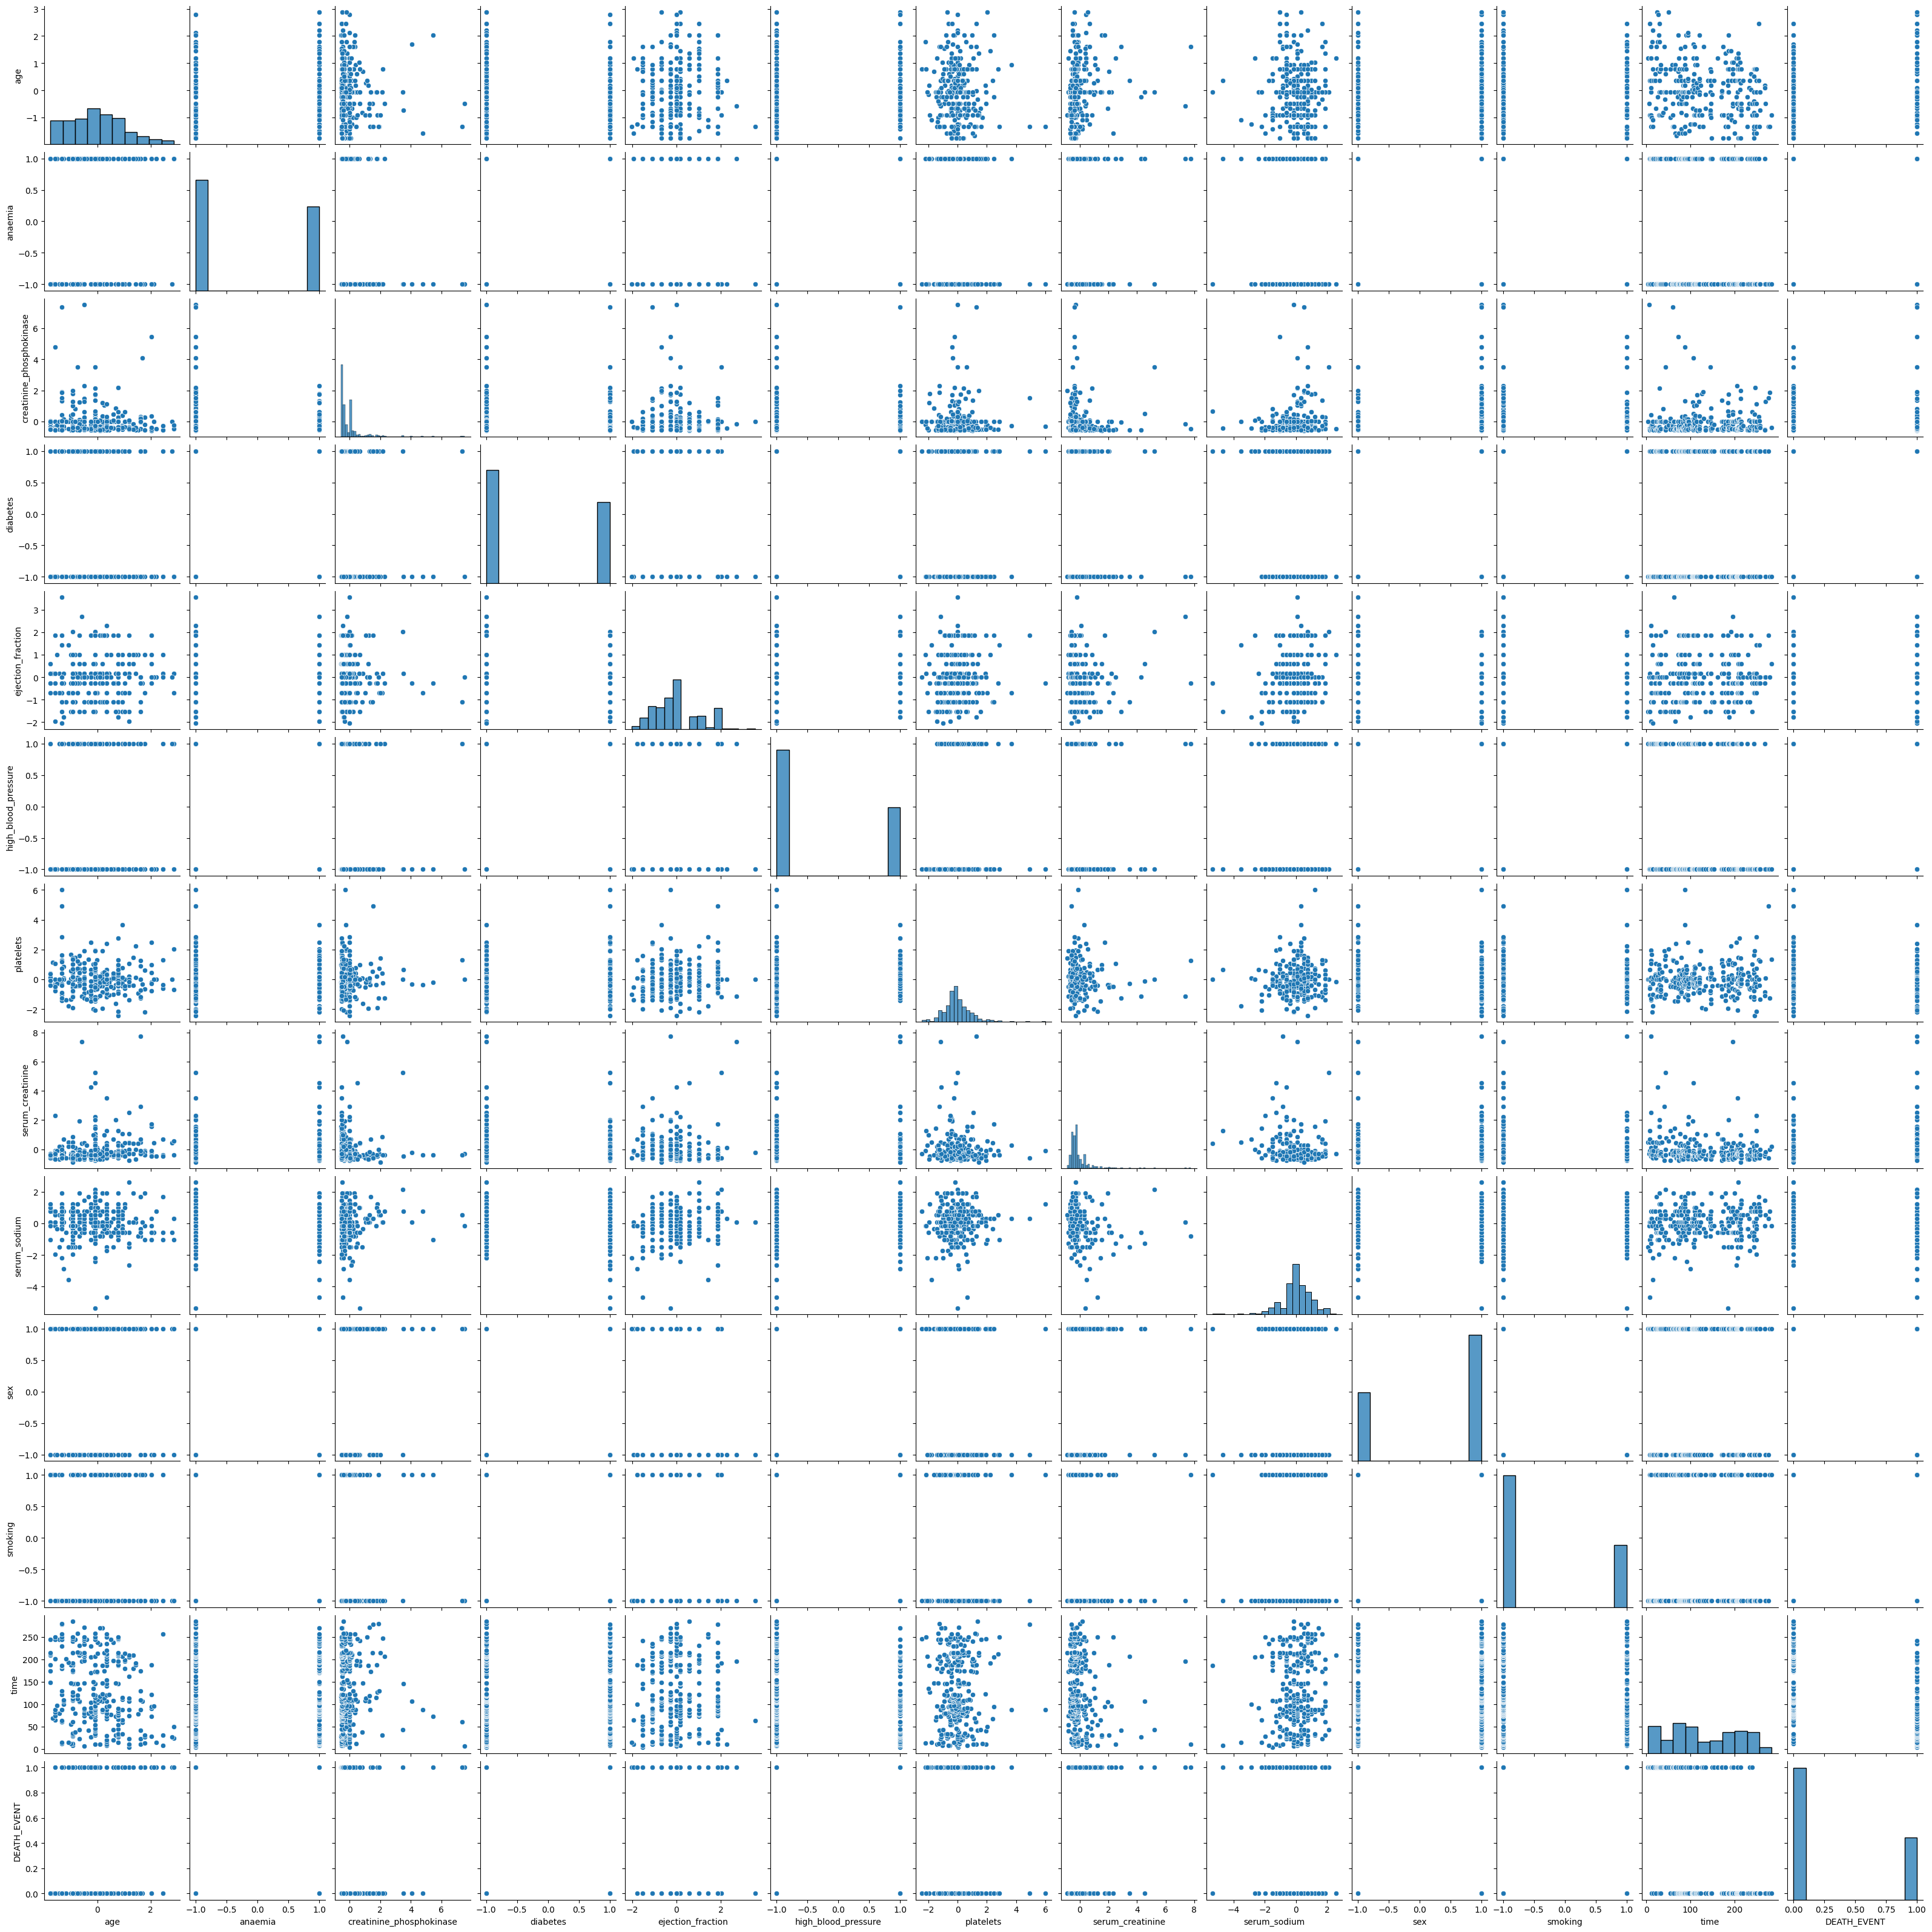

In [4]:
import seaborn as sns

sns.pairplot(data_norm)

## Pair plot
No se observa relacion clara entre atributos, tampoco es posible observar las relaciones entre atributos binarios, este tipo de atributos es mas sencillo observarlos a partir de una matriz de correlacion o visualizando la cantidad de valores que caen sobre cada uno de los 4 puntos que se pueden ver en las graficas donde ambos atributos son binarios.

Por desgracia podemos ver claros outliers en nuestro dataset. En el siguiente apartado nos centraremos en saber que muestras son y si borrarlas o no.

## Analisis de Outliers
En este apartado encontraremos aquellas muestras outliers descritas en el apartado anterior y intentaremos razonar si borrarlas o no.

### Busqueda de Outliers
Para encontrar aquellos valores outliers utilizaremos la regla del $3\sigma$. La cual nos dice que cualquier valor en una distribucion normal que sea mayor que $3\sigma$ (o menor que $-3\sigma$) es un outlier y se podria eliminar.

In [5]:
idx_outliers = set()
for columna in data_norm.columns[columnas_continuas]:
    sigma = data_norm[columna].std()
    is_more = data_norm[columna] > 3*sigma
    is_less = data_norm[columna] < -3*sigma

    is_more = is_more[is_more].index.values
    is_less = is_less[is_less].index.values

    if (len(is_more) + len(is_less) > 0):
        print(f"{columna} : detectados outliers")
        print("more:", is_more, "less:", is_less)

    idx_outliers = idx_outliers.union(is_more)
    idx_outliers = idx_outliers.union(is_less)

print(idx_outliers)
dataframe[dataframe.index.isin(idx_outliers)]

creatinine_phosphokinase : detectados outliers
more: [  1  52  60  72 103 134 171] less: []
ejection_fraction : detectados outliers
more: [64] less: []
platelets : detectados outliers
more: [105 109 296] less: []
serum_creatinine : detectados outliers
more: [  9  28  52 131 217 228] less: []
serum_sodium : detectados outliers
more: [] less: [  4  19 199]
{64, 1, 131, 4, 134, 199, 72, 9, 19, 217, 28, 228, 103, 296, 105, 171, 109, 52, 60}


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
1,55.0,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
4,65.0,1,160,1,20,0,327000.00,2.70,116,0,0,8,1
9,80.0,1,123,0,35,1,388000.00,9.40,133,1,1,10,1
19,48.0,1,582,1,55,0,87000.00,1.90,121,0,0,15,1
28,58.0,1,60,0,38,0,153000.00,5.80,134,1,0,26,1
52,60.0,0,3964,1,62,0,263358.03,6.80,146,0,0,43,1
60,45.0,0,7702,1,25,1,390000.00,1.00,139,1,0,60,1
64,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
72,85.0,0,5882,0,35,0,243000.00,1.00,132,1,1,72,1
103,42.0,0,5209,0,30,0,226000.00,1.00,140,1,1,87,0


#### Resultados de la busqueda
Podemos ver como hay una pequeña cantidad de muestras que segun ciertos atributos son outliers.
Tenemos un outlier que es outlier en varios atributos a la vez.

Se puede observar que nuestros outliers son tanto de falladas de corazon mortales como de falladas de corazon no mortales. Lo cual nos asegura que la mortalidad no esta correlacionada con los outliers y que la mortalidad podria ser predicha a partir de los datos del dataset.

Examinaremos todos los atributos en los que se han detectado outliers.

##### Creatinine Phosphokinase (mcg/L)
Los valores de una persona normal saludable son de 10 a 120 mcg/L. Podemos ver en nuestros outliers que hay bastante gente con valores bastante extremos de este atributo, es decir tienen 70 veces el valor maximo de una persona normal. Hay que tener en cuenta de que como estamos tratando datos de personas enfermas que han tenido ataques de corazon los valores de estos atributos no tienen por que seguir con el rango de una persona saludable, al contrario, seria raro que tuviesen valores dentro del rango de una persona saludable.

Debido a la falta de informacion en la web sobre este atributo ya que solo se obtienen recursos en otras medidas y estas no son faciles de pasar a mcg/L se considera que todas estas muestras son invalidas.


##### Ejection Fraction (percentage)
Solo encontramos un unico outlier en este atributo. Se trata de la muestra 64. La cual tiene una fraccion de ejeccion de 80 y no sufre una ataque de corazon mortal. Investigando en paginas medicas por internet se puede encontrar que el rango normal de la fraccion de ejeccion es de entre 50% y 75%.
Se han utilizado estas dos paginas:
- https://www.pennmedicine.org/updates/blogs/heart-and-vascular-blog/2022/april/ejection-fraction-what-the-numbers-mean
- https://www.texasheart.org/heart-health/heart-information-center/frequently-asked-patient-questions/is-80-ef-good-or-dangerous/

El primer link nos explica los diferentes valores de la fraccion de ejeccion y que significan. Nos dice tambien que una fraccion de ejeccion mas alta que el 80% puede indicar una condicion especifica de enfermedad del corazon. Por lo cual nos indica que puede ser perjudicial para la salud.

El siguiente link nos dice que una fraccion de ejeccion del 80% aunque sea alta podria ser normal.

A partir de estos datos obtenidos podemos llegar a la conclusion de que la persona relacionada con la muestra 64 debe de tener algun problema grave del corazon que ademas es bastante raro (se comprueba facilmente ya que es el unico outlier en esta categoria).

Al ser un outlier que trata de un caso muy especifico no lo tendremos en cuenta.

##### Platelets (kiloplatelets/mL)
Segun diversas paginas web el rango normal de plaquetas en la sangre es de 150 a 450 kiloplaquetas por microlitro de sangre. Este rango convertido a nuestros valores seria de entre 150000 a 450000 kiloplaquetas por mililitro de sangre.

Las muestras outliers que hemos encontrado sobrepasan el maximo de este rango hasta incluso llegar a 850000 la cual es casi el doble que este maximo. Si una persona tiene una gran cantidad de plaquetas en la sangre (mas de 450000) puede ser causa de un efecto secundario de alguna medicacion o indicar una condicion medica que podria poner en riesgo la salud de esta persona.

Las tres muestras encontradas son bastante parecidas pero al tener valores bastante extremos en este atributo no las consideraremos como muestras a utilizar.

##### Serum Creatinine (mg/dL)
El rango normal es de 0.74 a 1.35 mg/dL para hombres y 0.59 a 1.04 mg/dL para mujeres.
Las muestras outliers obtenidas superan este rango de forma considerable, llegando incluso a 9.4 mg/dL.
Valores altos pueden significar una enfermedad renal (enfermedad que afecta a riñones) o algun tipo de diabetes.

Observando las muestras vemos que solo 2 de las 6 que hay tienen diabetes. Lo cual nos indica que las 4 restantes tengan probablemente algun tipo de enfermedad renal.

No se consideraran como validas debido a la alta cantidad de errores que eso conllevaria.

##### Serum Sodium (mEq/L)
El rango normal es de 135 a 145 mEq/L.
Por lo general todas las muestras entran en este rango pero nuestros outliers tienen valores bastante bajos de este atributo. Al ser tan bajos pueden significar bastantes cosas. En este link se explican las posibles causas de unos valores bajos en una prueba de sodio sérico: https://www.ucsfhealth.org/medical-tests/sodium-blood-test

Nuestras muestras tienen valores bastante anormales de este atributo pero 2 de 3 fallecen y la ultima muestra tiene valores bastante normales en los otros atributos por lo tanto se consideraria que esta relativamente saludable y por lo tanto no ha habido riesgo que fallezca. De modo que las muestras outliers de esta categoria se tendran en cuenta.


### Eliminacion de outliers
Habiendo concretado que outliers vamos a proceder a eliminar realizaremos la eliminacion a continuacion.

In [6]:
columnas_con_outliers = [0, 2, 4, 6, 7]
idx_outliers = set()
for columna in data_norm.columns[columnas_con_outliers]:
    sigma = data_norm[columna].std()
    is_more = data_norm[columna] > 3*sigma
    is_less = data_norm[columna] < -3*sigma

    is_more = is_more[is_more].index.values
    is_less = is_less[is_less].index.values

    idx_outliers = idx_outliers.union(is_more)
    idx_outliers = idx_outliers.union(is_less)

print(idx_outliers)
data_filtered = dataframe[~dataframe.index.isin(idx_outliers)]

# volvemos a normalizar los datos
data_norm = data_filtered.copy()
data_norm[data_norm.columns[columnas_continuas]] = scale(data_norm[data_norm.columns[columnas_continuas]])
data_norm.describe()

{64, 1, 131, 134, 72, 9, 217, 28, 228, 103, 296, 105, 171, 109, 52, 60}


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,2.830000e+02,283.000000,283.000000,283.000000,2.830000e+02,283.000000,2.830000e+02,2.830000e+02,2.830000e+02,283.000000,283.000000,283.000000,283.000000
mean,6.276879e-17,0.438163,0.000000,0.424028,8.159943e-17,0.356890,2.714750e-16,3.766128e-17,-2.589213e-15,0.650177,0.314488,132.028269,0.310954
std,1.001771e+00,0.497040,1.001771,0.495070,1.001771e+00,0.479931,1.001771e+00,1.001771e+00,1.001771e+00,0.477759,0.465134,77.510095,0.463704
min,-1.780499e+00,0.000000,-0.813762,0.000000,-2.074299e+00,0.000000,-2.722936e+00,-1.267250e+00,-5.338815e+00,0.000000,0.000000,4.000000,0.000000
25%,-8.450763e-01,0.000000,-0.641966,0.000000,-6.811774e-01,0.000000,-5.597076e-01,-6.210955e-01,-5.904496e-01,0.000000,0.000000,74.000000,0.000000
50%,-7.973003e-02,0.000000,-0.401078,0.000000,1.538341e-02,0.000000,4.118905e-02,-2.980185e-01,8.788831e-02,1.000000,0.000000,119.000000,0.000000
75%,7.706547e-01,1.000000,0.230087,1.000000,6.248742e-01,1.000000,5.079049e-01,1.865969e-01,7.662262e-01,1.000000,1.000000,205.000000,1.000000
max,2.896616e+00,1.000000,4.360665,1.000000,2.366276e+00,1.000000,3.319868e+00,5.032752e+00,2.575127e+00,1.000000,1.000000,285.000000,1.000000


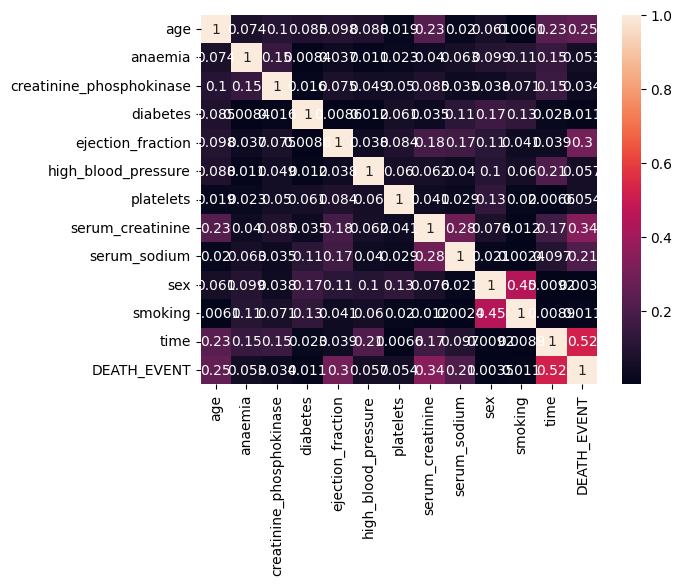

In [7]:
import matplotlib.pyplot as plt

corr = data_norm.corr()
sns.heatmap(abs(corr), annot=True)
plt.show()


## Correlacion
Se puede ver que hay relacion entre algunos atributos especificos. Los mas significativos serian:  
- Que una persona fume esta bastante correlacionado con su sexo.
- La hora a la que ha habido una fallada en el corazon tiene que ver con la mortalidad de esta fallada del corazon.

### Mortalidad
Para nuestro problema, podemos ver los atributos que mas influyen en la mortalidad de una fallada de corazon:
- La edad
- La fraccion de eyeccion
- El nivel de suero de creatinina
- El nivel de suero de sodio
- La hora de la muerte o censura (este link explica que significa esta columna y porque no vamos a utilizarla https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data/discussion/178372)

Curiosamente el resto de valores no estan correlacionados en tanta medida con la mortalidad pese a que uno pensaria que si, como por ejemplo si se tiene anemia o diabetes.
Otros valores en cambio como el sexo tienen sentido que no esten correlacionados con la mortalidad.

#### Posibles causas de baja correlacion de algunos casos
Una posible causa de esto sea que una persona diabetica seguramente esta siendo medicada por lo tanto su enfermedad no termina de afectarle en estos casos ya que la medicacion cumple la funcion que su cuerpo no puede hacer debido a la enfermedad.  
Lo mismo pasa en el caso de la anemia.  
Si una persona fuma causa daños en sus pulmones, aunque es algo perjudicial para la salud no tiene porque afectar al rendimiento del corazon por lo tanto la correlacion es baja.  
La alta presion en la sangre podria tener influencia en las falladas de corazon mortales ya que esta tiene que ver con el flujo de sangre por el cuerpo pero segun el dataset parece que no hay clara correlacion.  
El resto de atributos son valores medicos que se examinaran mas adelante si es necesario.  


### PCA
Para poder observar que atributos aportan mas informacion en conjunto utilizaremos un PCA. A partir del cual obtendremos unas graficas que nos diran el porcentaje que aporta cada atributo al componente del PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_group = pca.fit_transform(data_norm[data_norm.columns[0:-2]])

df_pca_g = pd.DataFrame({'PC1' : pca_group[:, 0], 'PC2' : pca_group[:, 1], 'DEATH_EVENT' : data_norm['DEATH_EVENT']})

<AxesSubplot: title={'center': 'PCA'}>

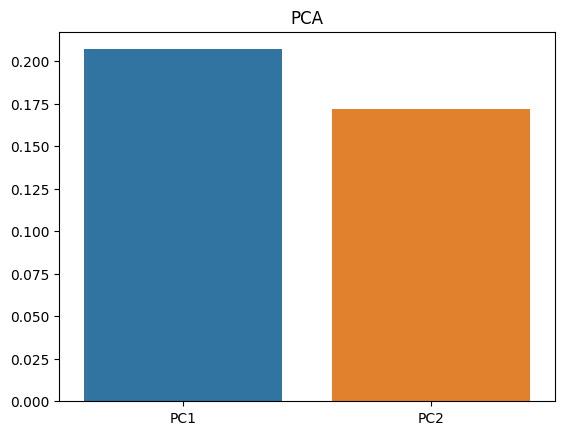

In [9]:
pca.explained_variance_ratio_           # variancia de la "PC1" i "PC2" generades
pca.explained_variance_ratio_.sum()     # variancia total

plt.figure()
plt.title("PCA")
sns.barplot(x=["PC1", "PC2"], y=pca.explained_variance_ratio_)

#### Primeros resultados
Podemos ver que el PCA ha conseguido obtener dos componentes con una variancia bastante elevada.

Ahora passaremos a ver a partir de que atributos se generan estos dos componentes principales.

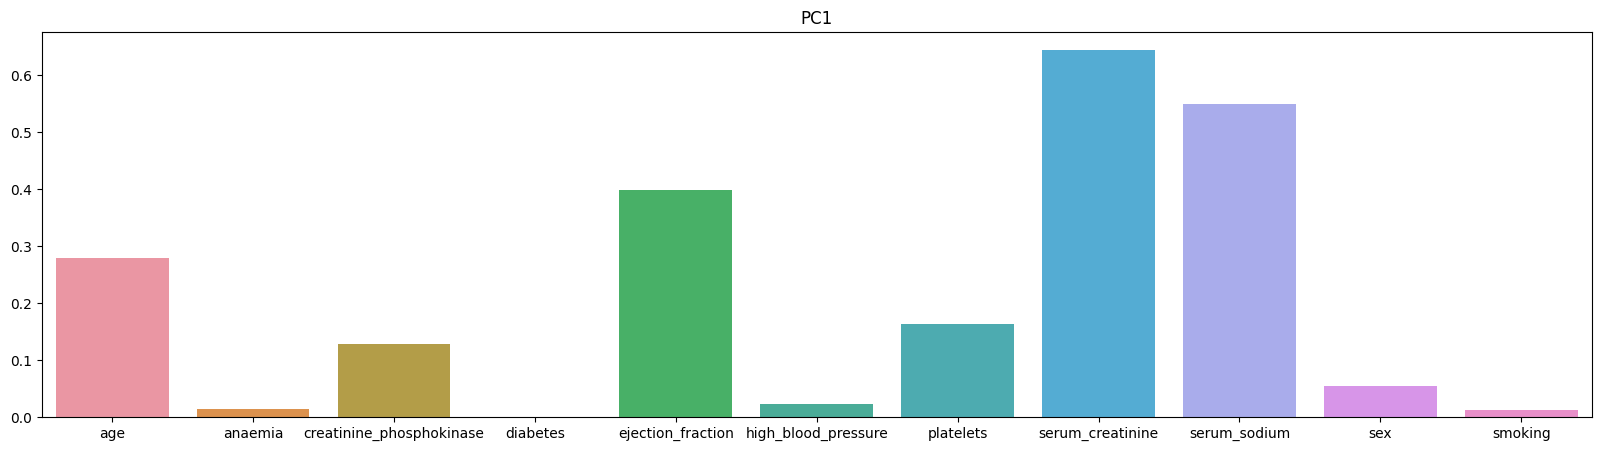

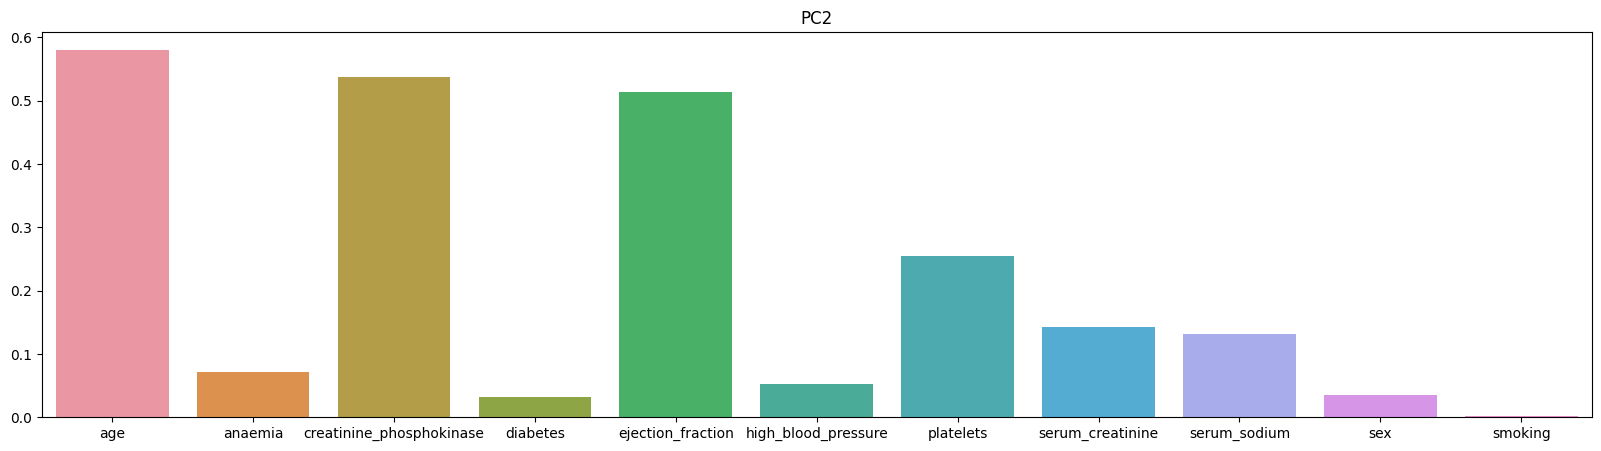

In [10]:
plt.figure(figsize=(20, 5))
plt.title("PC1")
sns.barplot(x=data_norm.columns[0:-2], y=abs(pca.components_[0]))
plt.show()

plt.figure(figsize=(20, 5))
plt.title("PC2")
sns.barplot(x=data_norm.columns[0:-2], y=abs(pca.components_[1]))
plt.show()

#### Analisis de atributos del PCA

Podemos ver que los atributos que proporcionan una mayor variancia en el PC1 son: (ordenados de mayor influencia a menor)
- El suero de creatinina
- El suero de sodio
- La fraccion de ejeccion
- La edad
- Numero de plaquetas (celula que influye en la coagulacion de la sangre)
- La creatininia phosphokinoasa

Los atributos del PC2 no cambian mucho pero se le deja de dar importancia a los dos atributos que influian mas en el componente anterior y por lo tanto los atributos que proporcionan una mayor variancia en el PC2 son: (ordenados de mayor influencia a menor)
- La edad
- La creatinina phosphokinoasa
- La fraccion de ejeccion
- Numero de plaquetas
- El suero de creatinina
- El suero de sodio

Finalmente se muestra el grafico con los datos transformados por el PCA:

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

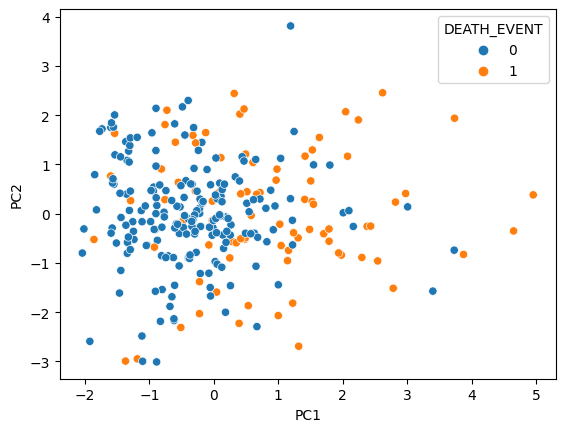

In [11]:
sns.scatterplot(x="PC1", y="PC2", hue=df_pca_g["DEATH_EVENT"], data=df_pca_g)

#### Resultados del PCA
Como podemos ver en el grafico el PCA no logra obtener una diferenciacion lo suficientemente grande para poder separar los datos correctamente. Se puede observar que hay una diferencia de densidad entre las muestras azules y naranjas (persona que ha muerto o ha sido censurada), pero esta diferencia no es lo suficientemente grande como para que podamos separarlas facilmente.

Quizas con un numero mayor de componentes se podria visualizar una separacion mayor, pero el PCA no se suele utilizar para clasificacion sino para obtener un analisis de componentes y saber que atributos se podrian eliminar sin consecuencia.


### T-SNE
Como el PCA no ha sido util para poder visualizar nuestros datos correctamente vamos a utilizar el T-SNE, el cual podria darnos una visualizacion mucho mas exacta y separada de nuestros datos.
Esto se debe a que el PCA utiliza una forma muy simple de reducir las dimensiones, cada componente es una combinacion lineal de los parametros que solo intenta maximizar la variancia, en cambio el T-SNE utiliza una forma mucho mas compleja la cual no se describira por su alta complejidad.

<AxesSubplot: xlabel='C1', ylabel='C2'>

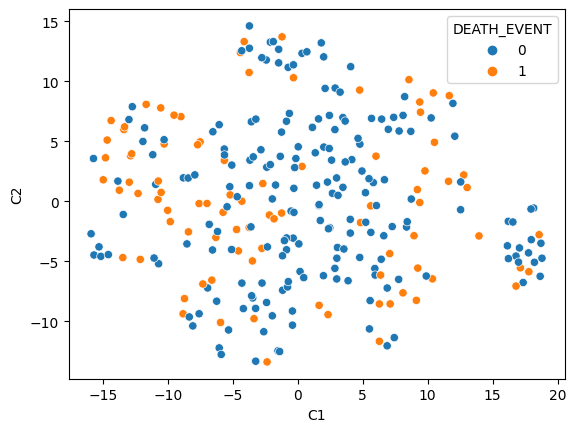

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_group = tsne.fit_transform(data_norm[data_norm.columns[0:-2]])

df_tsne_g = pd.DataFrame({'C1' : tsne_group[:, 0], 'C2' : tsne_group[:, 1], 'DEATH_EVENT' : data_norm['DEATH_EVENT']})

sns.scatterplot(x="C1", y="C2", hue=df_tsne_g["DEATH_EVENT"], data=df_tsne_g)

#### Resultados del T-SNE
Podemos ver que aunque no se han obtenido resultados demasiado buenos estos son mejores que los del PCA ya que podemos ver como en el centro de la grafica se encuentran la mayoria de muestras con `DEATH_EVENT` = 0 con algunas excepciones como a la derecha donde encontramos un cumulo de muestras parecidas. Mientras que las muestras en las tenemos un `DEATH_EVENT` = 1 se encuentran en los bordes de las muestras de la clase mencionada anteriormente.
Debido a este razonamiento es muy posible que las muestras se puedan clasificar con un KNN o metodos parecidos.

## Generacion de modelos inicial
En los siguientes apartados desarrollaremos varios modelos para separar ambas clases.

Estos modelos se generaran con parametros por defecto y al final ajustaremos aquellos modelos que nos hayan dado mejores resultados.

### Preparacion de datos
Primero de todo separaremos los datos en los atributos `X` y `y` y despues los separaremos en los datos de train y test.


In [13]:
from sklearn.model_selection import train_test_split
train_test = data_norm.copy()
train_test.pop('time')              # eliminamos esta columna ya que es de resultados
y = train_test.pop('DEATH_EVENT')
X = train_test

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
215,1.025770,0,0.230087,0,-0.245827,1,-0.647217,0.025058,-0.590450,1,0
27,0.770655,0,-0.628895,1,0.624874,1,0.297883,0.025058,-0.138224,1,1
93,-0.079730,1,-0.569139,0,-1.116528,0,-0.565542,0.671212,-0.364337,1,0
152,-0.930115,0,-0.641966,0,0.624874,1,-0.868907,-0.621096,-0.590450,1,1
192,-0.930115,1,-0.630762,1,0.189524,0,0.017853,-0.944173,-1.494900,1,0
...,...,...,...,...,...,...,...,...,...,...,...
201,-1.355307,0,-0.281567,1,1.930926,1,1.382997,-0.459557,-0.138224,1,0
78,1.195847,1,-0.477639,1,0.015383,1,0.286215,-1.105711,-1.268788,1,1
116,-0.079730,1,-0.677446,1,1.930926,1,0.146200,-0.944173,-0.138224,0,0
285,-0.504922,1,-0.539262,1,0.189524,0,0.904613,-0.136480,-0.364337,1,0


### Funcion de analisis
Tambien especificaremos una funcion de analisis que mostrara diversos graficos que se adaptan a nuestro problema.

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

def show_analisys(model, X_test, y_test, name="Model name", can_proba = False):
    ### confusion matrix
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    ### precision-recall curve
    if can_proba:
        try:
            y_score = model.predict_proba(X_test)[:, 1]

            #calculate precision and recall
            precision, recall, thresholds = precision_recall_curve(y_test, y_score)

            #create precision recall curve
            fig, ax = plt.subplots()
            ax.plot(recall, precision, color='purple')

            no_skill = len(y_test[y_test==1]) / len(y_test)
            ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

            #add axis labels to plot
            ax.set_title(f'Precision-Recall Curve of {name}')
            ax.set_ylabel('Precision')
            ax.set_xlabel('Recall')

            #display plot
            plt.show()
        except Exception as err:
            print("Error found:", err)


### Decision tree

Como primer modelo a entrenar se utilizara un decision tree, ya que es un clasificador relativamente sencillo y no lineal.

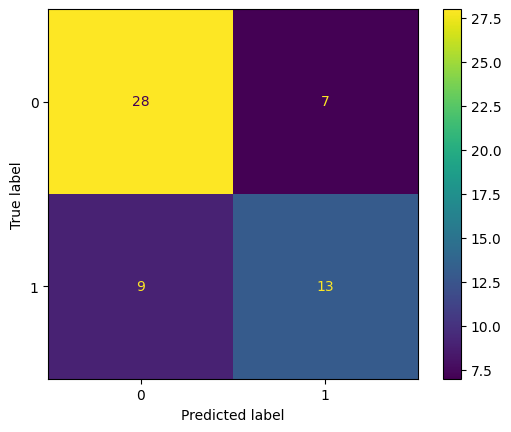

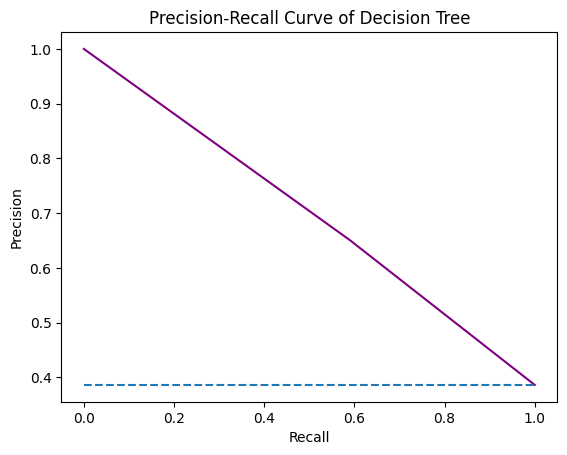

In [39]:
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

model = tree.DecisionTreeClassifier(random_state=42)
model = model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# 
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show()
show_analisys(model, X_test, y_test, "Decision Tree", True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21860\2638524994.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


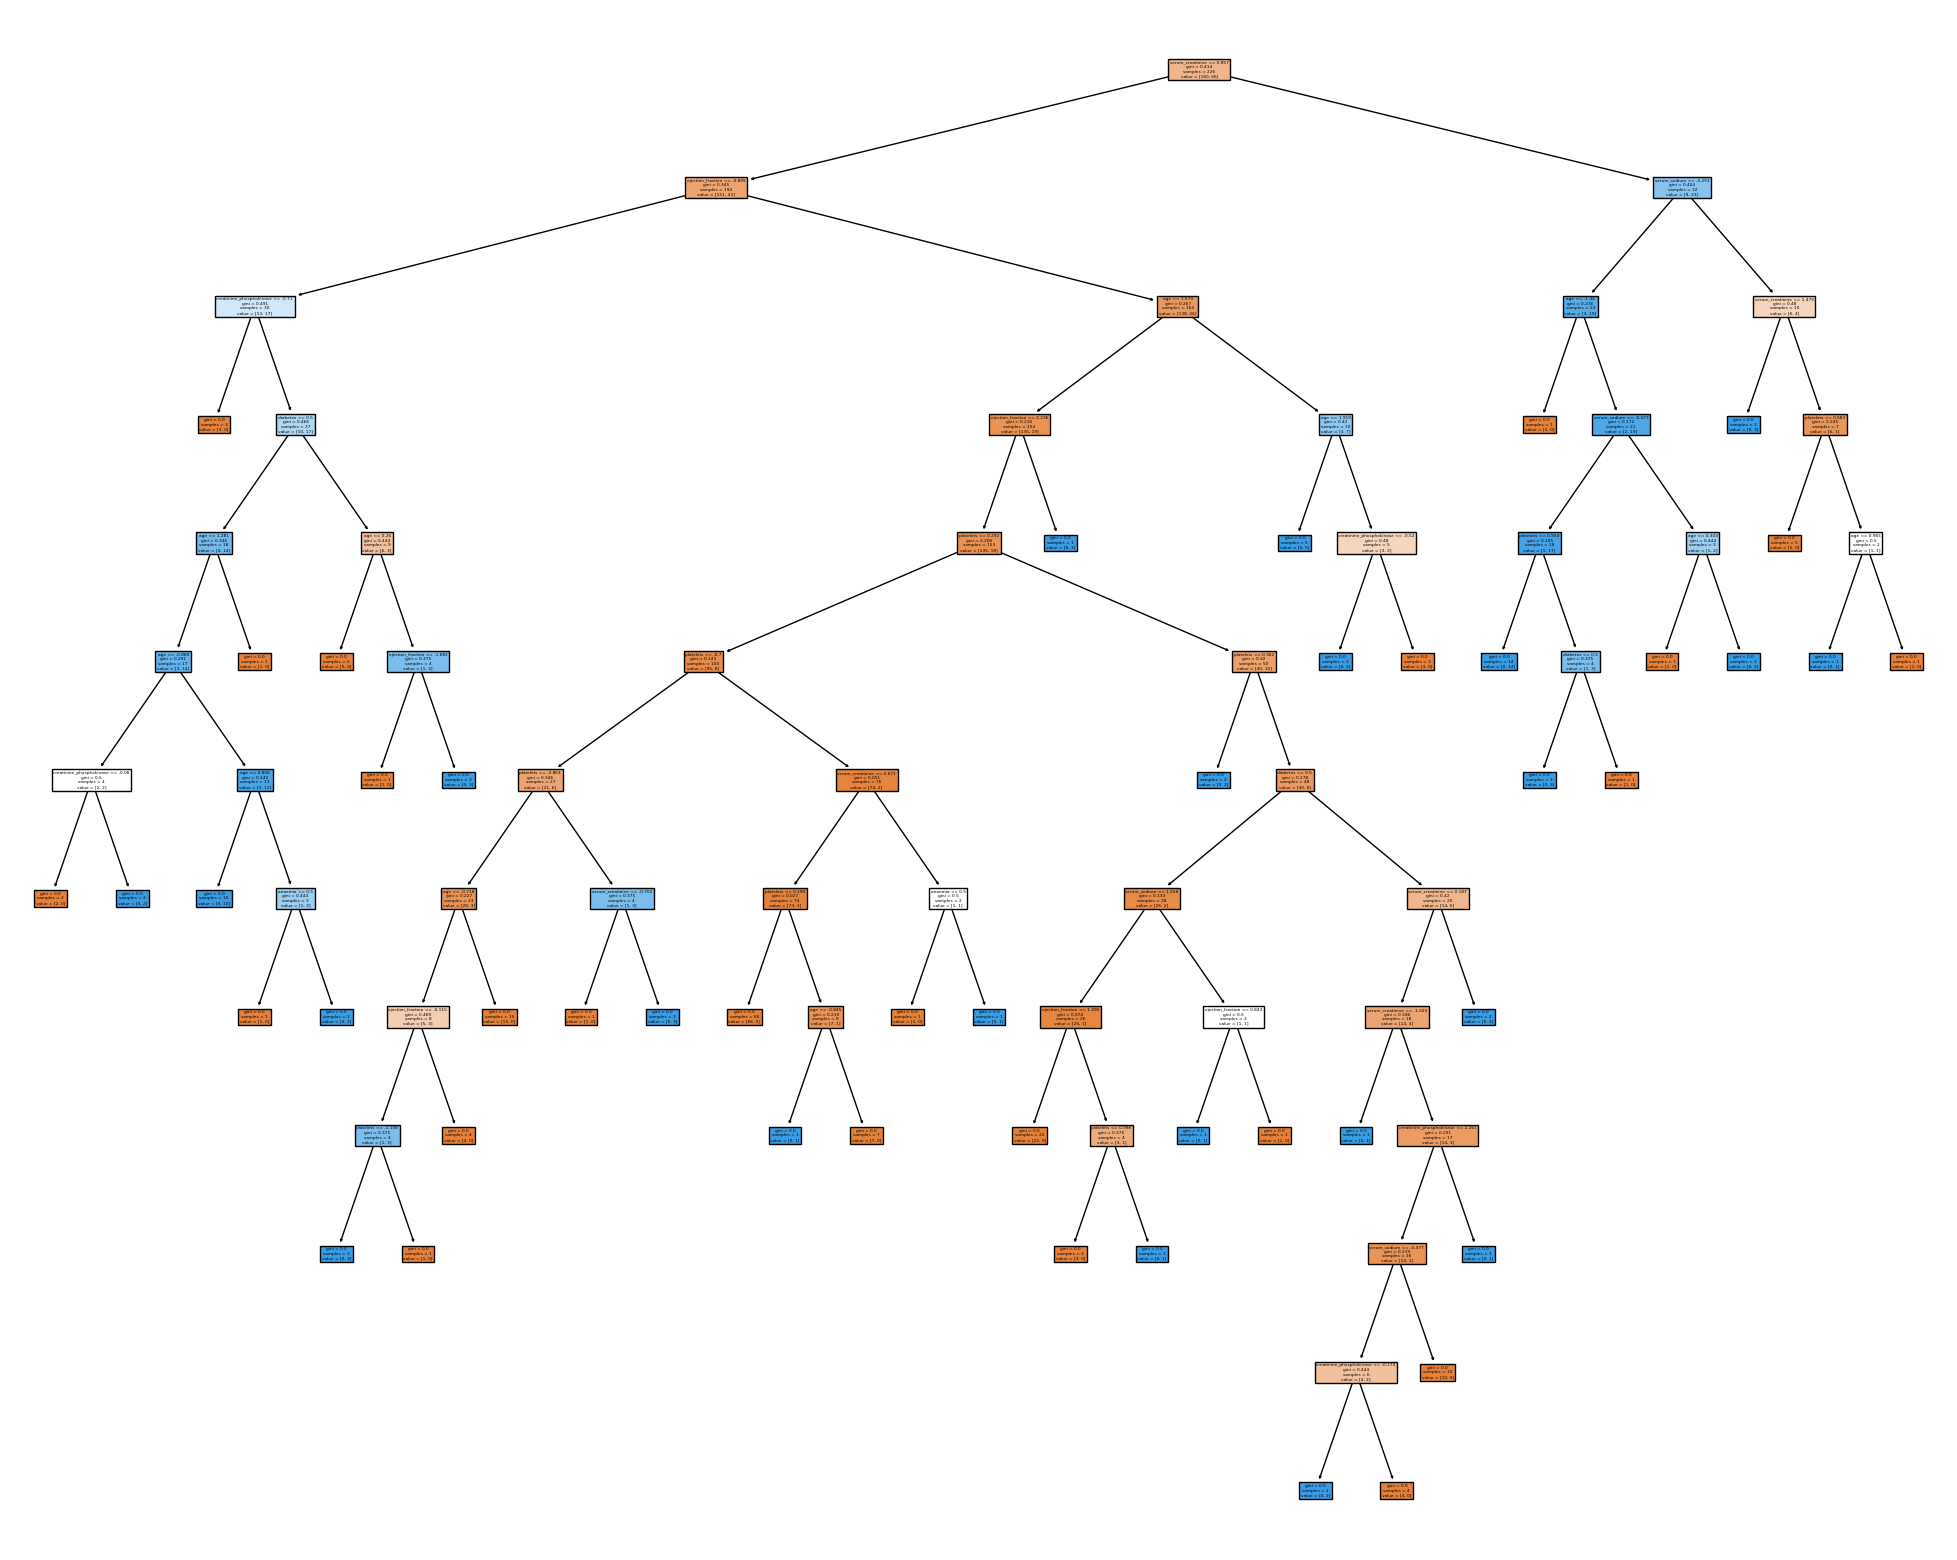

In [16]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, feature_names=X_train.columns, filled=True)
fig.show()

#### Resultados
##### Matriz de confusion
Como podemos ver en la grafica no hemos podido obtener unos buenos resultados.
De las 22 muestras que habia en el test que han sido mortales solo hemos podido predecir 13.
##### Arbol generado
Podemos ver que el arbol hace unas separaciones bastante claras en algunos casos pero no consigue separar bien las muestras en otros. Tambien se puede observar como hay una rama en la cual se tiene que especificar mucho para separar entre ambas clases y por lo tanto acaba generando muchas ramas y obtiene una profundidad bastante elevada. Hay ramas generadas por incluso 12 nodos.

#### Proximos modelos
En las proximos modelos nos centraremos en intentar aumentar esta metrica, es decir en aumentar todo lo posible el recall aunque por ello perdamos precision.

### Random forest
Probaremos a utilizar un random forest para ver si este obtiene mejores resultados al utilizar menos atributos y ser generado aleatoriamente.

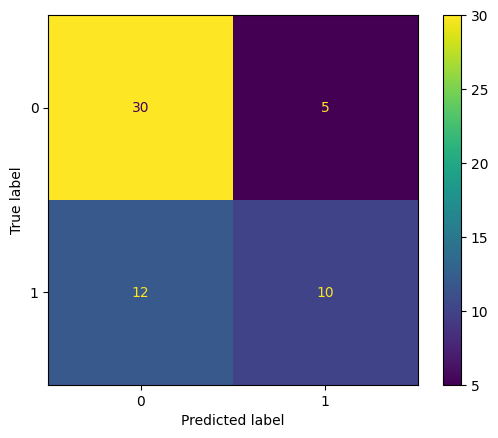

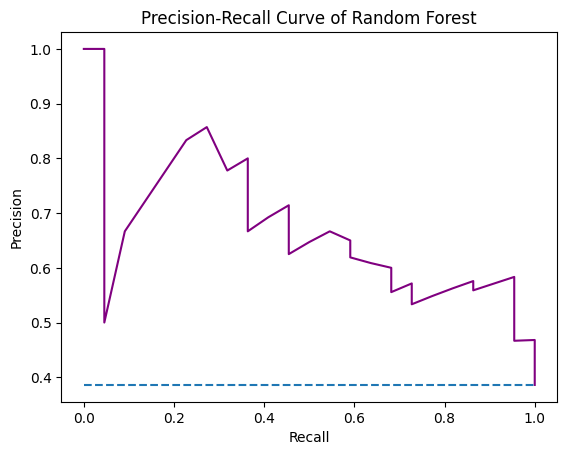

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# 
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show()
show_analisys(model, X_test, y_test, "Random Forest", True)

#### Resultados
El rendimiento del modelo ha empeorado, obtenemos un menor recall que antes: antes 13/22 y ahora 10/22.

Debido a como funciona el Random Forest significa que los atributos de las muestras que tenemos estan conjuntamente correlacionados con la clase a predecir. Es decir que la clase a predecir se podria definir a partir de una combinacion de los otros atributos.


### Modelos mas especificos
Como hemos podido observar los modelos que hemos escogido no han obtenido resultados lo suficientemente buenos como para poder obtener un recall alto.
Utilizaremos la siguiente grafica para escoger los modelos que entrenaremos a continuacion:

![images/scikit-learn-algorithms.png](images/scikit-learn-algorithms.png)

A partir de esta grafica podemos elejir que modelo utilizar segun nuestras necesidades.

En nuestro caso tenemos mas de 50 muestras, predecimos una categoria y tenemos datos con etiquetas (el atributo `DEATH_EVENT`), por lo tanto tenemos un problema de clasificacion.
A partir de esto continuamos con el grafo, tenemos menos de 100K muestras por lo tanto probaremos un Linear SVC, en caso de que no funcione como no tenemos datos con texto utilizaremos en Knn y si este no funciona utilizaremos SVC mas complejos y clasificadores ensemble.

Ya hemos utilizado un clasificador ensemble, el random forest, pero buscaremos mas para comprobar el rendimiento de estos.

### Linear SVC
Un SVC lineal deberia de separar las clases rapidamente si estas son separables linealmente. Como es muy improbable que esto suceda estableceremos un soft-margin para que tarde menos.

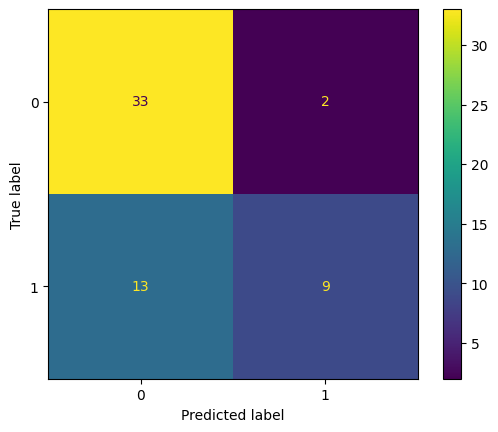

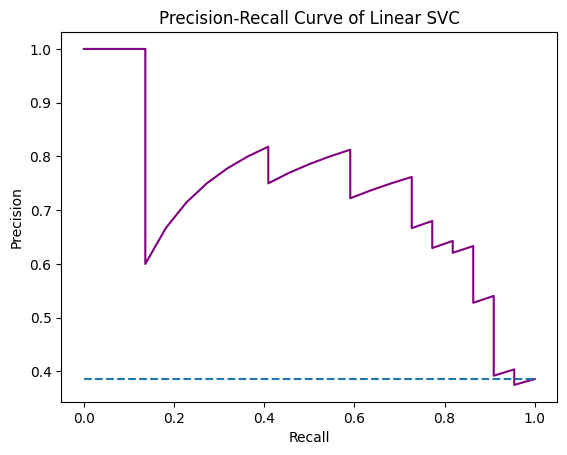

In [18]:
from sklearn.svm import SVC

model = SVC(kernel="linear", probability=True, random_state=42)
model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show()
show_analisys(model, X_test, y_test, "Linear SVC", True)

#### Resultados
Podemos observar que el recall no es muy bueno. Es tan solo de 9/22 a comparacion con el decision tree este es un resultado bastante pobre de manera que continuaremos con los siguientes modelos que aparecian en el grafico.

Cabe destacar que este modelo ha obtenido una precision bastante alta a comparacion con los modelos anteriormente utilizados: 9/11

### KNeighbors
Como el SVC lineal no ha podido clasificar correctamente utilizaremos el siguiente clasificador que aparecia en la grafica, es decir el clasificador KNeighbors.

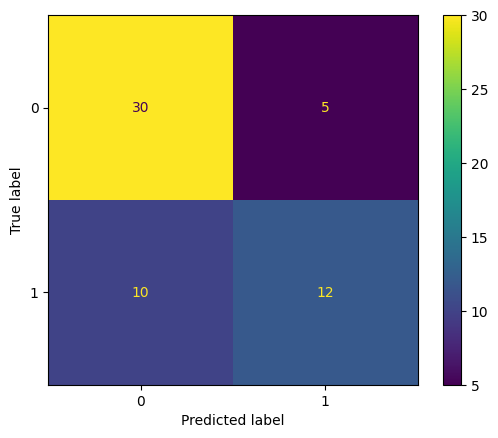

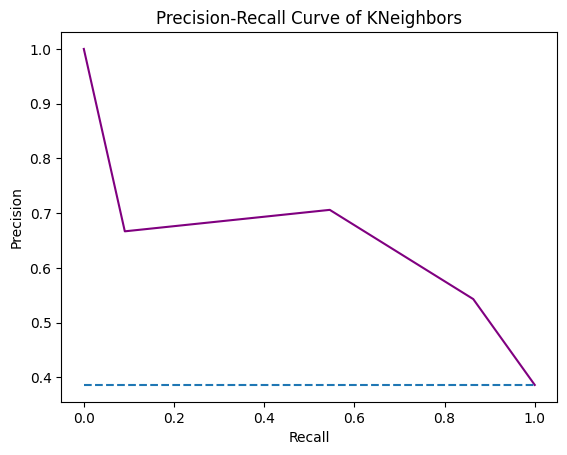

In [19]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# 
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show()
show_analisys(model, X_test, y_test, "KNeighbors", True)

#### Resultados
Obtenemos una mejora respecto al SVC lineal y el random forest en relacion a ambas metricas mencionadas en apartados anteriores, el precision y el recall. Por desgracia estos resultados no son tan buenos como el decision tree, por lo tanto seguiremos probando distintos modelos.

Igualmente intentaremos mejorar este modelo posteriormente ajustando hiperparametros.

### SVC
Probaremos diversos kernels del SVC para comprobar todas las opciones posibles, como ya hemos comprobado el kernel lineal solo tendremos que comprobar el kernel rfb, el kernel polinomico y el kernel sigmoidea.

#### Kernel polinomico

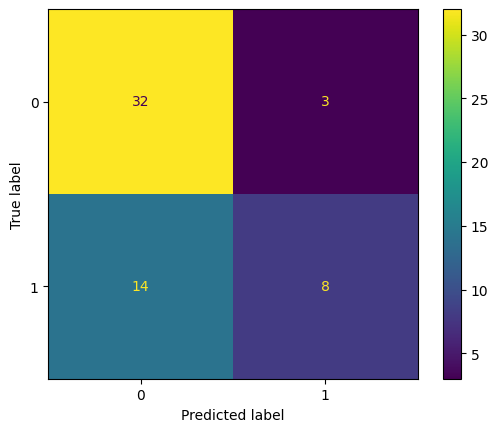

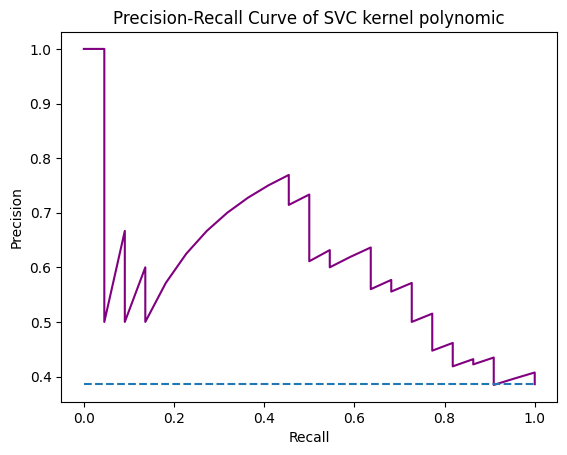

In [20]:
from sklearn.svm import SVC

model = SVC(kernel="poly", probability=True, random_state=42)
model.fit(X_train, y_train)

show_analisys(model, X_test, y_test, "SVC kernel polynomic", True)

##### Resultados
Perdemos recall frente a otros clasificadores por lo tanto este kernel no funciona en nuestro problema.

#### Kernel rbf

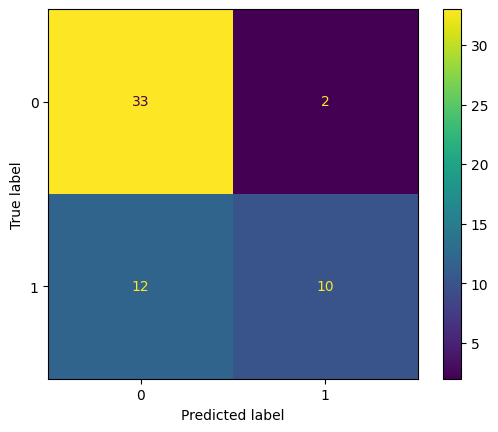

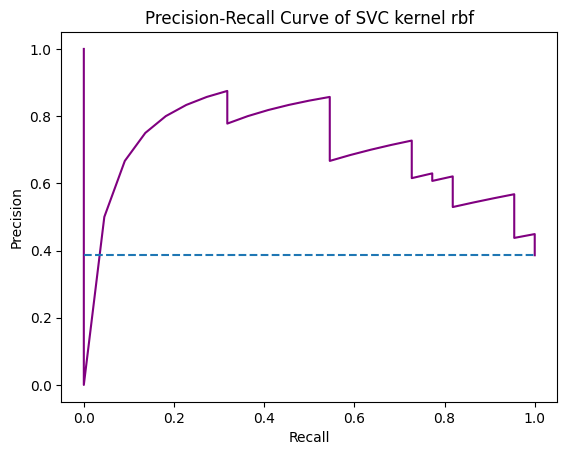

In [21]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", probability=True, random_state=42)
model.fit(X_train, y_train)

show_analisys(model, X_test, y_test, "SVC kernel rbf", True)

##### Resultados
Obtiene un buen recall comparado con otros modelos probados, pero sigue sin ser tan bueno como el decision tree y el knn.

#### Kernel sigmoidea

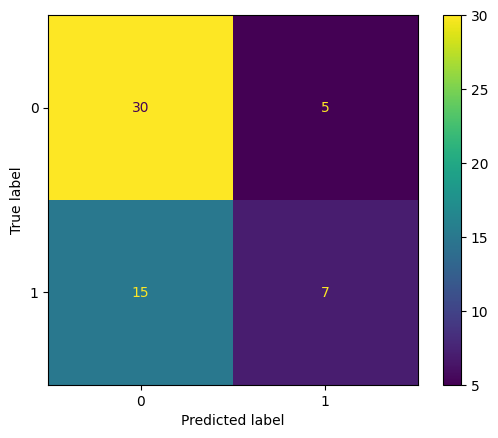

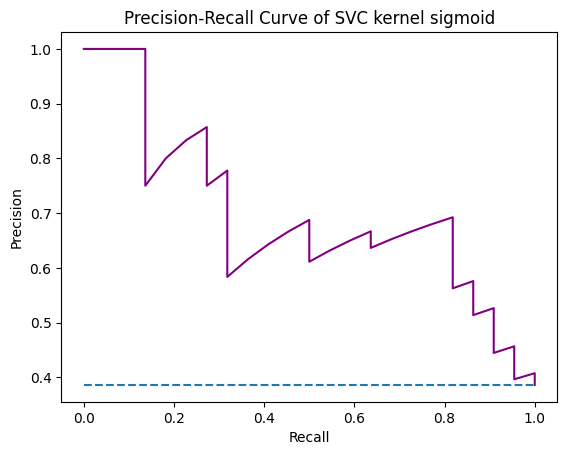

In [22]:
from sklearn.svm import SVC

model = SVC(kernel="sigmoid", probability=True, random_state=42)
model.fit(X_train, y_train)

show_analisys(model, X_test, y_test, "SVC kernel sigmoid", True)

##### Resultados
Obtenemos resultados muy parecidos a los del kernel polinomico, por lo tanto este kernel no funciona para nuestro problema.

#### Resultados finales del SVC
Los resultados no han sido muy buenos en general. Cabe destacar que el kernel rbf ha funcionado bien y probablemente se intentara mejorar con distintos parametros en los proximos apartados.

De todas formas no se han obtenido los resultados esperados y continuaremos probando modelos distintos.

### Ensemble Classifiers
Los clasificadores ensemble utilizan multiples modelos simples para obtener una prediccion correcta.

En este apartado probaremos diversos clasificadores.

#### ADA Boost


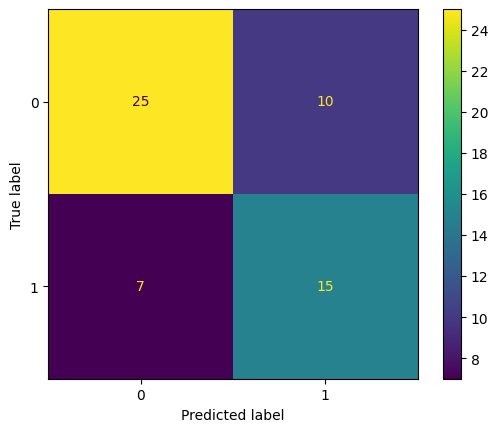

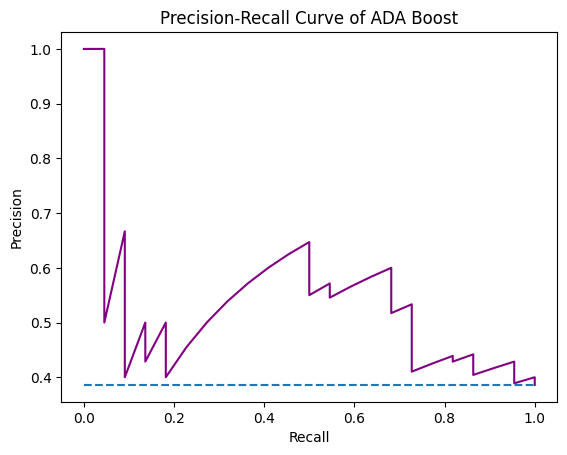

In [23]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)
model.fit(X_train, y_train)

show_analisys(model, X_test, y_test, "ADA Boost", True)

##### Resultados
Se obtienen resultados bastante buenos a partir de este clasificador, se pierde precision pero no es algo que nos importe realmente ya que queremos obtener el recall mas grande posible.

#### Extremely randomized trees

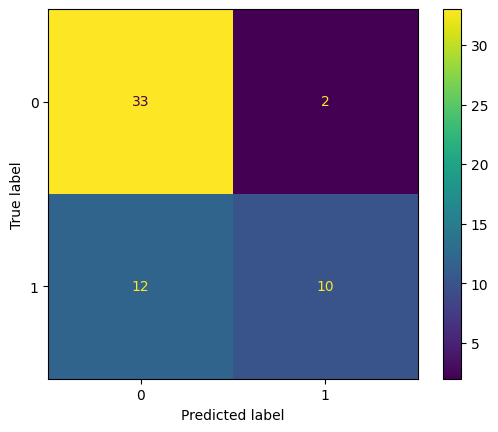

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

##### Resultados
Se obtiene una buena precision, pero el recall sigue siendo bastante bajo.

### Resultados de la generacion de modelos inicial
A partir de estos modelos generados escogeremos aquellos que hayan obtenido un buen rendimiento y consideramos que podrian mejorar cambiando algunos hiperparametros del clasificador.

Los modelos escogidos son:
- Decision Tree
- Random forest
- KNeighbors
- SVC con kernel rbf
- ADA Boost


## Mejora de los modelos

En este apartado nos centraremos en mejorar los hiperparametros de los modelos escogidos en el apartado anterior.
### Metodos utilizados
Utilizaremos un grid search para modelos con pocas configuraciones de hiperparametros y un random search para modelos con muchas configuraciones de hiperparametros, despues de hacer un random search haremos un grid search mas especifico para ajustar el modelo mas exactamente. 
Ademas utilizaremos una funcion especial del estos metodos de busqueda para especificar nuestro objetivo. En este caso utilizaremos el $F_1$ score ya que se centra mas en obtener una buena precision y un buen recall. En el caso de que algun modelo obtenga buena precision pero mal recall cambiaremos este objetivo a un score personalizado llamado $F_\beta$ score con un valor de $\beta$ elevado para que tenga mas importancia el recall que la precision.

In [119]:
from sklearn.metrics import confusion_matrix, make_scorer
## Funcion objetivo
def f1_score(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)

    recall_sub = conf[1][0] + conf[1][1]
    precision_sub = conf[0][1] + conf[1][1]
    if (recall_sub == 0 or precision_sub == 0):
        return 0
    recall = conf[1][1] / recall_sub
    precision = conf[1][1] / precision_sub

    f1_sub = precision + recall
    if f1_sub == 0:
        return 0
    f1 = 2*((precision*recall)/f1_sub)
    return f1

β = 1.25        # valor β del Fβ score
def f_beta_score(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)

    recall_sub = conf[1][0] + conf[1][1]
    precision_sub = conf[0][1] + conf[1][1]
    if (recall_sub == 0 or precision_sub == 0):
        return 0
    recall = conf[1][1] / recall_sub
    precision = conf[1][1] / precision_sub

    f_beta_sub = ((β**2)*precision)+recall
    if f_beta_sub == 0:
        return 0
    f_beta = (1 + β**2)* ((precision*recall)/f_beta_sub)
    return f_beta



my_scorer = make_scorer(f1_score, greater_is_better=True)
my_second_scorer = make_scorer(f_beta_score, greater_is_better=True)


### Decision Tree


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=None, min_samples_split=2, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=4, random_state=42; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_spl

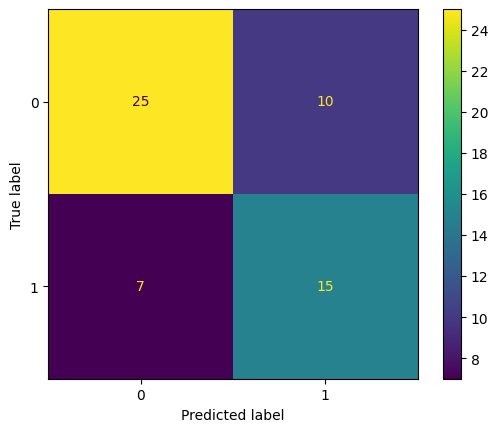

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'criterion': ["gini", "entropy", "log_loss"],
        'min_samples_split' : [2, 4, 8],
        'max_depth' : [None, 6, 8, 10],
        'random_state' : [42]
    },
]


grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=2, scoring=my_scorer)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Se han mejorado los resultados que habiamos obtenido anteriormente.
Hemos pasado de un recall de 13/22 a 15/22.
Los parametros optimos han sido utilizar el criterio 'entropy' y dejar el resto como default.

### Random Forest


#### Random Search

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2000, random_state=42; total time=   1.7s
[CV] END bootstrap=False, criterion=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2000, random_state=42; total time=   1.7s
[CV] END bootstrap=False, criterion=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2000, random_state=42; total time=   1.7s
[CV] END bootstrap=False, criterion=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2000, random_state=42; total time=   1.7s
[CV] END bootstrap=False, criterion=log_loss, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2000, random_state=42; total time=   1.7s
[CV] END bootstrap=True, criterion=log_loss, max_dept

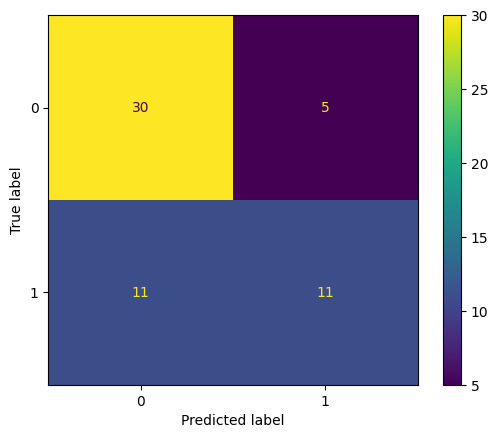

In [105]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_rand = [
    {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
        'criterion': ["gini", "entropy", "log_loss"],
        'min_samples_split' : [2, 4, 8, 16],
        'min_samples_leaf' : [1, 2, 4, 8],
        'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'max_features': ["sqrt", "log2"],
        'bootstrap' : [True, False],
        'random_state' : [42]
    },
]

rand = RandomizedSearchCV(RandomForestClassifier(), param_rand, n_iter=50, refit=True, verbose=2, scoring=my_scorer, n_jobs=4)
rand.fit(X_train,y_train)

print(rand.best_estimator_)

rand_predictions = rand.predict(X_test)
print(classification_report(y_test,rand_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, rand_predictions)
plt.show()

#### Grid Search
En el random search anterior hemos obtenido los siguientes hiperparametros:  
bootstrap=False, max_depth=9, min_samples_leaf=4, min_samples_split=4, n_estimators=1577  
En el grid search intentaremos ajustar estos valores para que sean mas exactos

Fitting 5 folds for each of 192 candidates, totalling 960 fits
RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=1400, random_state=42)
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        35
           1       0.69      0.50      0.58        22

    accuracy                           0.72        57
   macro avg       0.71      0.68      0.68        57
weighted avg       0.71      0.72      0.71        57



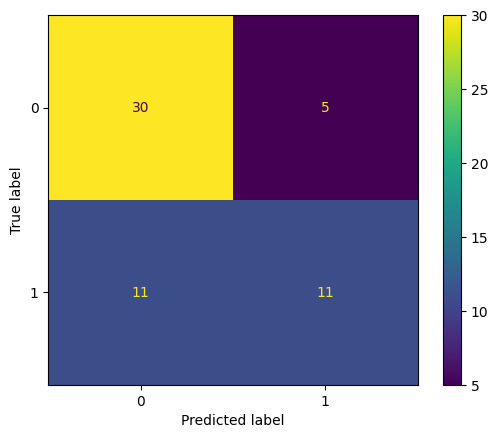

In [107]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'n_estimators': [1400, 1500, 1600, 1700],
        'min_samples_split' : [3, 4, 5, 6],
        'min_samples_leaf' : [3, 4, 5, 6],
        'max_depth' : [ 8, 9, 10],
        'bootstrap' : [False],
        'random_state' : [42]
    },
]

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2, scoring=my_scorer, n_jobs=4)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Se ha conseguido mejorar el resultado pero no es suficiente como para compararse con el decision tree.


### KNeighbors

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, n_neighbors=3, p=

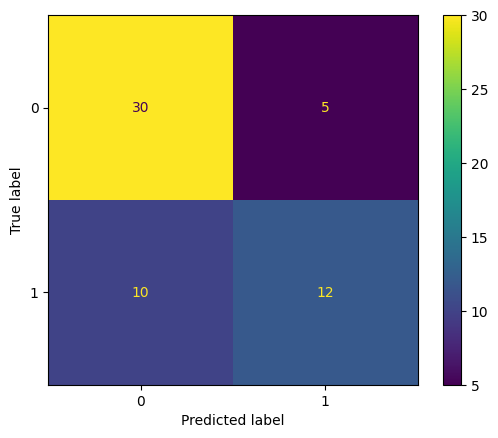

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'n_neighbors': [3, 5, 7],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p' : [1, 2, 3]     # distancias de manhattan, euclidea y de minkowski
    },
]

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=2, scoring=my_second_scorer)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Se ha probado el $F_1$ score y ha tenido resultados peores que los parametros originales de manera que se ha cambiado el scoring a el $F_\beta$ score.

El knn tiene como parametros optimos n_neighbors=3.

### SVC con kernel rbf


Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END ........C=0.1, gamma=1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ........C=0.1, gamma=1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ........C=0.1, gamma=1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ........C=0.1, gamma=1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ........C=0.1, gamma=1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ......C=0.1, gamma=0.1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ......C=0.1, gamma=0.1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ......C=0.1, gamma=0.1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ......C=0.1, gamma=0.1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END ......C=0.1, gamma=0.1, kernel=rbf, random_state=42; total time=   0.0s
[CV] END .....C=0.1, gamma=0.01, kernel=rbf, random_state=42; total time=   0.0s
[CV] END .....C=0.1, gamma=0.01, kernel=rbf, ra

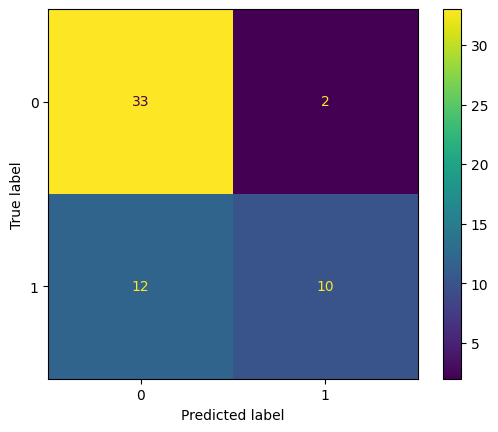

In [102]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001, 'scale'],
        'kernel': ['rbf'],
        'random_state' : [42]
    },
]

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, scoring=my_scorer)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Los mejores parametros han sido C=1000 y gamma=0.001, por desgracia el rendimiento ha sido peor del esperado.

### ADA Boost

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END learning_rate=0.1, n_estimators=75, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=75, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=75, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=75, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=75, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, random_state=42; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=150, random_state=42; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=

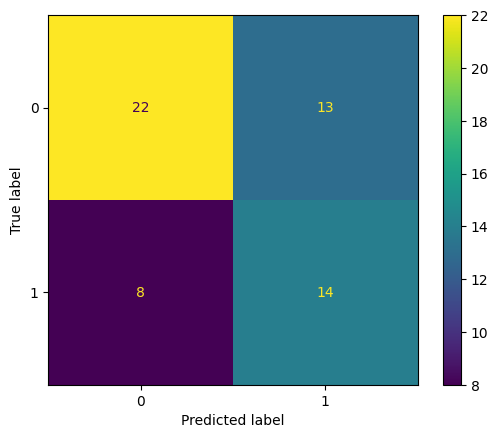

In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Support Vector Machine Linear Kernel

param_grid = [
    {
        'n_estimators': [75, 100, 150, 200],
        'learning_rate': [0.1, 0.5, 0.75, 1, 1.25, 2],
        'random_state' : [42],
    },
]

grid = GridSearchCV(AdaBoostClassifier(), param_grid, refit=True, verbose=2, scoring=my_second_scorer)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)
plt.show()

#### Resultados
Hemos obtenido unos resultados bastante buenos pero ha disminuido el recall esto se debe a que no estamos comprobando con los datos de test sino que se hace una cross validation para obtener los hiperparametros. Esto asegura que no obtengamos overfitting a partir de los hiperparametros.

Los parametros optimos de este modelo han sido:
learning_rate=1, n_estimators=75

### Resultados de la mejora de parametros

El modelo que nos ha dado mejores resultados ha sido el decision tree optimizado y el ADA Boost por defecto.

## Muestras no clasificadas correctamente
En este apartado examinaremos esas muestras que realmente eran `DEATH_EVENT`=1 en las que los modelos han predicho `DEATH_EVENT`=0.

### Decision Tree
Inicializamos el decision tree con los parametros que hemos obtenido y obtenemos la lista de muestras con falsos negativos.

In [37]:
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

model = tree.DecisionTreeClassifier(criterion="entropy", random_state=42)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_filter = y_pred==0
y_filter[y_pred==y_test] = False
dataframe.loc[X_test[y_filter].index]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
181,59.0,1,176,1,25,0,221000.0,1.0,136,1,1,150,1
49,57.0,1,129,0,30,0,395000.0,1.0,140,0,0,42,1
66,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
75,60.0,1,47,0,20,0,204000.0,0.7,139,1,1,73,1
84,59.0,1,280,1,25,1,302000.0,1.0,141,0,0,78,1
186,50.0,0,582,0,50,0,153000.0,0.6,134,0,0,172,1
7,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1


#### Analisis
Todas estas muestras se predicen como `DEATH_EVENT`=0 pero tendrian que ser `DEATH_EVENT`=1.  
Observando estas muestras se puede observar que son bastante parecidas de forma que podria significar un caso de underfitting.  
Se han comparado algunos de estos valores con los rangos normales obtenidos en el apartado de tratamiento de outliers.  
Se puede observar lo siguiente:
- Rango de edades parecido (de entre 57 a 60 menos 2 muestras que son mucho mas inferiores, 42 y 50)
- Todos tienen anemia (menos una de las muestras)
- Todas las muestras tienen valores elevados de creatinina phosphokinoasa, menos una (observando los datos del dataset podemos ver que esto es normal)
- Todas las muestras (menos dos) tienen baja fraccion de ejeccion
- Ninguna de las muestras tiene alta presion sanguinea (menos una que si que tiene)
- Suero de creatinina correcto
    - Las mujeres rondan entre 0.6 y 1.0 (menos una muestra que tiene un valor demasiado alto de 1.3)
    - Los hombres rondan entre 0.7 y 1.1 lo cual es el rango normal.
- Suero de sodio correcto (cabe destacar que las 2 muestras que tenian una fraccion de ejeccion normal tienen valores bajos de este atributo)

A partir de estos resultados se puede formular una hipotesis: **Se necesita una cantidad mas elevada de datos ya que hay casos que no se estan entrenando en el decision tree pero que deberian.**

### ADA Boost
Comprobaremos si las muestras que fallan son las mismas que en el decision tree, si es correcto no haria falta examinarlas y la hipotesis descrita anteriormente probablemente seria cierta.

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay

model = AdaBoostClassifier(random_state=42)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_filter = y_pred==0
y_filter[y_pred==y_test] = False
dataframe.loc[X_test[y_filter].index]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
11,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10,1
181,59.0,1,176,1,25,0,221000.0,1.0,136,1,1,150,1
49,57.0,1,129,0,30,0,395000.0,1.0,140,0,0,42,1
167,59.0,0,66,1,20,0,70000.0,2.4,134,1,0,135,1
36,90.0,1,60,1,50,0,226000.0,1.0,134,1,0,30,1
66,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
186,50.0,0,582,0,50,0,153000.0,0.6,134,0,0,172,1


Valores que fallan en el decision tree (ordenados):
- 7, 49, 66, 75, 84, 181, 186

Valores que fallan en el ADA Boost (ordenados):
- 11, 36, 49, 66, 167, 181, 186

Podemos ver que hay algunas muestras que coinciden:
- 49, 66, 181, 186

Estas muestras que coinciden son bastante raras, ya que tienen valores normales en muchas de sus atributos. Por lo tanto es muy probable que se prediga incorrectamente debido a que muchas muestras con atributos parecidos han dado que si que sobrevirian.
Tambien es posible que al tener atributos normales y como se trata de un dataset con datos de personas que han sufrido ataques de corazon, no sea normal que haya muestras con atributos en el rango normal.

Despues de observar ambas colecciones de muestras incorrectamente clasificadas se puede llegar a una conclusion. Al ser muestras con muchos atributos y al tener un dataset de personas enfermas es poco probable que con la cantidad de datos que tenemos haya suficientes muestras con atributos normales para poder predecir correctamente la mortalidad en esos casos.

Por lo tanto la hipotesis anteriormente formulada es incorrecta pero si que tenia algo correcto, hay una falta de datos considerable para poder predecir correctamente la mortalidad.

## Exportacion de los modelos obtenidos
En este apartado procederemos a exportar nuestros modelos para que se puedan ejecutar posteriormente de forma facil.
Entrenaremos estos modelos con el dataset entero para asi obtener unos mayores rendimientos en tests con datasets con los mismos atributos pero con muestras distintas.

### Preparacion de los datos

In [41]:
from sklearn.model_selection import train_test_split
train_test = data_norm.copy()
train_test.pop('time')              # eliminamos esta columna ya que es de resultados
y = train_test.pop('DEATH_EVENT')
X = train_test

from joblib import dump         # libreria para guardar objetos de python en un archivo para poder cargarlos posteriormente
                                # Nota: Se necesita tener la misma version ya que el cambio del codigo original podria ocasionar problemas

MODEL_FOLDER = '../../models'   # carpeta donde se guardaran los modelos entrenados

### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", random_state=42)
model = model.fit(X, y)

dump(model, f'{MODEL_FOLDER}/decision_tree.joblib')

['../../models/decision_tree.joblib']

### ADA Boost

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from joblib import dump

model = AdaBoostClassifier(random_state=42)
model = model.fit(X, y)

dump(model, f'{MODEL_FOLDER}/ada_boost.joblib')

['../../models/ada_boost.joblib']

### Comprobacion de la exportacion de modelos
Se probara a cargar ambos modelos generados y se hara un pequeño test, los resultados seran mas buenos que los de las ejecuciones anteriores debido a que ahora se esta haciendo un test con los mismos datos de entrenamiento pero para esta pequeña demostracion sirve.

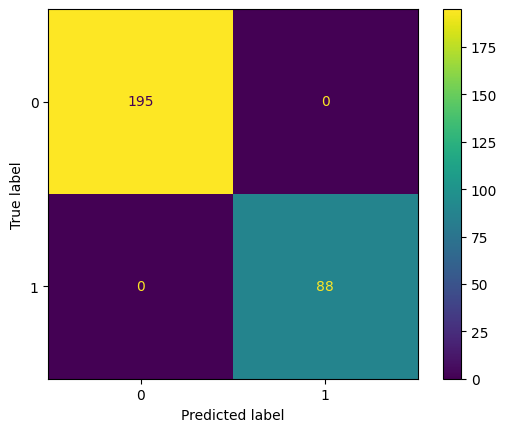

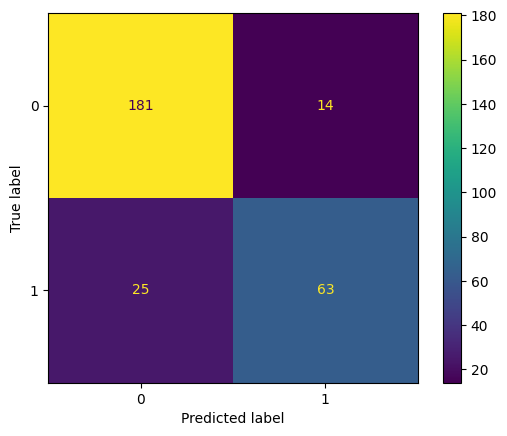

In [46]:
# ... dataset cargado anteriormente
# ... separados los atributos de 'X' y 'y' correctamente y se han normalizado

# cargado del modelo
from joblib import load

decision_tree = load(f'{MODEL_FOLDER}/decision_tree.joblib')

show_analisys(decision_tree, X, y)

ada_boost = load(f'{MODEL_FOLDER}/ada_boost.joblib')

show_analisys(ada_boost, X, y)

Podemos ver que ambos modelos se cargan correctamente y se obtienen predicciones acorde al comportamiento descrito anteriormente.

## Comparacion de modelos
En este apartado investigaremos otros modelos hechos por otras personas que hayan sido subidas en la web del dataset de Kaggle.

La mayoria de modelos encontrados utilizan el atributo time el cual es un atributo de resultados y por lo tanto no deberia de ser utilizado con el entrenamiento.
Esto es debido a que cuando un paciente sufre una fallada de corazon se le examina y se realiza un periodo de follow-up donde se le examina continuamente para intentar mejorar su estado de salud. Por lo tanto se ve reflejado en el periodo de follow-up ya que este no es el periodo entero sino el periodo desde que se sufre la fallada de corazon hasta su recuperacion o su fallecimiento de manera que al fallecer este periodo de follow-up se trunca hasta el dia de su fallecimiento. Tambien es posible que una persona no quiera ser examinada y por lo tanto salga del periodo de follow-up por cuenta propia, en ese caso el intervalo suele ser menor pero necesita una cierta cantidad de dias para recuperarse y por lo tanto estos casos no afectan al atributo `time` demasiado. Ademas utilizando datos reales, este periodo seria desconocido.  

Esta es la razon por la cual no se deberia de utilizar el atributo `time`.

https://www.kaggle.com/code/prasadposture121/heart-failure-prediction#Heart-Failure-Prediction  
Este notebook de kaggle esta realizado con modelos que utilizan el atributo `time` pero se ha modificado el codigo para borrar esta columna y asi comparar el rendimiento de nuestros modelos.
Sus modelos obtienen un 0.76 y un 0.746 de accuracy con la separacion de datos de train y test en 0.25 y random_state=2.
Por desgracia sus modelos bajan muchisimo de accuracy en cuanto varias la separacion de datos de train y test.
Cambiando el random_state a 42 se obtienen unas accuracy de 0.66 y 0.66.

https://www.kaggle.com/code/nayansakhiya/heart-fail-analysis-and-quick-prediction#Data-Modeling  
Este notebook (el mas votado), tambien esta realizado con modelos que utilizan el atributo `time` y se ha modificado el codigo para que este atributo no se utilice.
Sus modelos obtienen las siguientes accuracies con un random_state=2 en la separacion de train y test:
![images/accuracy-modelos-notebook-mas-votos-random2.png](images/accuracy-modelos-notebook-mas-votos-random2.png)

Igual que en notebook anterior al cambiar el random state estas acuracies bajan muchisimo:
![images/accuracy-modelos-notebook-mas-votos-random42.png](images/accuracy-modelos-notebook-mas-votos-random42.png)

Con esto podemos concluir que el random_state afecta bastante a los resultados de nuestros modelos y que muchas personas los utilizan como si fuesen hiperparametros, cuando no deberian. Al alterar el random_state de esta forma intentan que los datos a validar se parezcan mucho a los datos a entrenar, de esta manera si ocurre overfitting no se obtienen unos malos resultados.

Al con los modelos generados en este notebook los cuales obtienen un 70% de acuracy incluso con un random_state de 42 en la separacion de train y test, se obtienen resultados mucho mejores que en los notebooks examinados.

## Conclusiones

Hemos podido obtener 2 modelos diferentes, un Decision Tree y un ensemble method llamado ADA Boost.
En ambos modelos obtenemos los mismos resultados, obtenemos recalls del 68% y precision del 60%. Obtendriamos tambien un accuracy del 70% y un $F_1$ score del 64%.

Hemos podido comprobar que los modelos que hemos obtenido no son tan malos como pensabamos ya que otras personas tambien obtienen resultados parecidos a los nuestros.


## Ideas para trabajar en un futuro
Creo que seria interesante investigar mas sobre este tipo de datasets y poder encontrar un modelo que pueda obtener unas predicciones mucho mejores.
